In [74]:
#Import libraries:
import pandas as pd
import numpy as np
import xgboost as xgb
from xgboost.sklearn import XGBClassifier
#from sklearn import cross_validation,
from sklearn import metrics   #Additional scklearn functions
from sklearn.model_selection import GridSearchCV   #Perforing grid search

import matplotlib.pylab as plt

from matplotlib import pyplot

%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 4

train = pd.read_csv('../data/loan_train.csv',encoding='utf-8')
target = 'Disbursed'
IDcol = 'ID'

In [75]:
train.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,ID000002C20,Female,Delhi,20000,23-May-78,15-May-15,300000.0,5.0,0.0,CYBOSOL,...,NaN,NaN,NaN,N,Web-browser,G,S122,1,0,0
1,ID000004E40,Male,Mumbai,35000,07-Oct-85,04-May-15,200000.0,2.0,0.0,TATA CONSULTANCY SERVICES LTD (TCS),...,13.25,NaN,6762.9,N,Web-browser,G,S122,3,0,0
2,ID000007H20,Male,Panchkula,22500,10-Oct-81,19-May-15,600000.0,4.0,0.0,ALCHEMIST HOSPITALS LTD,...,NaN,NaN,NaN,N,Web-browser,B,S143,1,0,0
3,ID000008I30,Male,Saharsa,35000,30-Nov-87,09-May-15,1000000.0,5.0,0.0,BIHAR GOVERNMENT,...,NaN,NaN,NaN,N,Web-browser,B,S143,3,0,0
4,ID000009J40,Male,Bengaluru,100000,17-Feb-84,20-May-15,500000.0,2.0,25000.0,GLOBAL EDGE SOFTWARE,...,NaN,NaN,NaN,N,Web-browser,B,S134,3,1,0


In [76]:
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()

columns = ["Gender", "City", "Employer_Name"]

for col in train.columns:
    train[col] = labelencoder.fit_transform(train[col].astype(str))
    
train.head()

,ID,Gender,City,Monthly_Income,DOB,Lead_Creation_Date,Loan_Amount_Applied,Loan_Tenure_Applied,Existing_EMI,Employer_Name,...,Interest_Rate,Processing_Fee,EMI_Loan_Submitted,Filled_Form,Device_Type,Var2,Source,Var4,LoggedIn,Disbursed
0,0,0,172,2318,8592,44,133,6,0,8691,...,73,571,4530,0,1,6,0,1,0,0
1,1,1,446,4315,2704,11,86,3,0,38690,...,3,571,3721,0,1,6,0,3,0,0
2,2,1,497,2831,3833,56,216,5,0,1833,...,73,571,4530,0,1,1,16,1,0,0
3,3,1,568,4315,11066,26,6,6,0,5698,...,73,571,4530,0,1,1,16,3,0,0
4,4,1,87,6,6240,59,193,3,1514,13513,...,73,571,4530,0,1,1,8,3,1,0


In [77]:
#imported 2 forms of XGBoost:
#xgb – this is the direct xgboost library. I will use a specific function “cv” from this library
#XGBClassifier – this is an sklearn wrapper for XGBoost. This allows us to use sklearn’s Grid Search with parallel processing in the same way we did for GBM

In [78]:
import hashlib

def computeMD5hash(my_string):
    m = hashlib.md5()
    m.update(my_string.encode('utf-8'))
    return m.hexdigest()

#define a function which will help us create XGBoost models and perform cross-validation. 
def modelfit(alg, dtrain, predictors,useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=dtrain[target].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
            metrics='auc', early_stopping_rounds=early_stopping_rounds)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], dtrain['Disbursed'],eval_metric='auc')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print("\nModel Report")
    print("Accuracy : %.4g" % metrics.accuracy_score(dtrain['Disbursed'].values, dtrain_predictions))
    print("AUC Score (Train): %f" % metrics.roc_auc_score(dtrain['Disbursed'], dtrain_predprob))
    print(xgb_param)
    # plot
    test_means = cvresult['test-auc-mean']
    test_stds = cvresult['test-auc-std'] 
        
    train_means = cvresult['train-auc-mean']
    train_stds = cvresult['train-auc-std'] 

    x_axis = range(0, cvresult.shape[0])
    
    pyplot.errorbar(x_axis, test_means, yerr=test_stds ,label='Test')
    pyplot.errorbar(x_axis, train_means, yerr=train_stds ,label='Train')
    pyplot.title("XGBoost n_estimators vs auc")
    pyplot.xlabel( 'n_estimators' )
    pyplot.ylabel( 'AUC' )
    pyplot.savefig( 'n_estimators'+computeMD5hash(str(xgb_param))+'.png' )

    pyplot.show()
    #print("feature score " + alg.booster().get_fscore())
    #feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    #feat_imp.plot(kind='bar', title='Feature Importances')
    #plt.ylabel('Feature Importance Score')



In [79]:
#https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/
#1.Choose a relatively high learning rate. Generally a learning rate of 0.1 works but somewhere between 0.05 to 0.3 should work for different problems. Determine the optimum number of trees for this learning rate. XGBoost has a very useful function called as “cv” which performs cross-validation at each boosting iteration and thus returns the optimum number of trees required.
#2.Tune tree-specific parameters ( max_depth, min_child_weight, gamma, subsample, colsample_bytree) for decided learning rate and number of trees. Note that we can choose different parameters to define a tree and I’ll take up an example here.
#3.Tune regularization parameters (lambda, alpha) for xgboost which can help reduce model complexity and enhance performance.
#4.Lower the learning rate and decide the optimal parameters .

Step 1: Fix learning rate and number of estimators for tuning tree-based parameters

In order to decide on boosting parameters, we need to set some initial values of other parameters. Lets take the following values:

    max_depth = 5 : This should be between 3-10. I’ve started with 5 but you can choose a different number as well. 4-6 can be good starting points.
    min_child_weight = 1 : A smaller value is chosen because it is a highly imbalanced class problem and leaf nodes can have smaller size groups.
    gamma = 0 : A smaller value like 0.1-0.2 can also be chosen for starting. This will anyways be tuned later.
    subsample, colsample_bytree = 0.8 : This is a commonly used used start value. Typical values range between 0.5-0.9.
    scale_pos_weight = 1: Because of high class imbalance.



Model Report
Accuracy : 0.9933
AUC Score (Train): 0.997589
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'missing': None, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8, 'verbosity': 0}


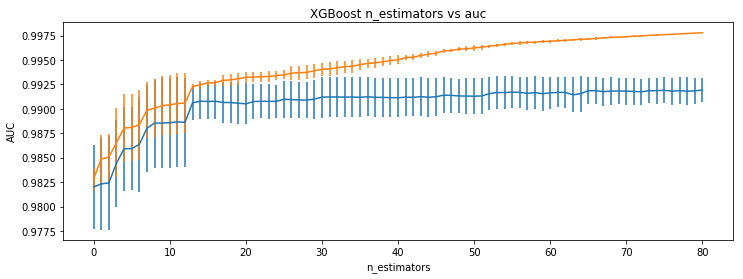

In [80]:
predictors = [x for x in train.columns if x not in [target, IDcol]]
xgb1 = XGBClassifier(
     learning_rate =0.1,
     n_estimators=1000,
     max_depth=5,
     min_child_weight=1,
     gamma=0,
     subsample=0.8,
     colsample_bytree=0.8,
     objective= 'binary:logistic',
     nthread=4,
     scale_pos_weight=1,
     seed=27)
modelfit(xgb1, train, predictors)

Step 2: Tune max_depth and min_child_weight
I’ll be doing some heavy-duty grid searched in this section which can take 15-30 mins or 
even more time to run depending on your system. 
You can vary the number of values you are testing based on what your system can handle.

In [81]:
#https://blog.csdn.net/nitric_acid/article/details/80490476
max_depth_param = list(range(3,10,3))
min_child_weight_param = list(range(1,6,3))

param_test1 = dict(max_depth=max_depth_param, min_child_weight=min_child_weight_param)
param_test1

{'max_depth': [3, 6, 9], 'min_child_weight': [1, 4]}

In [82]:
gsearch1 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=5,
          min_child_weight=1, gamma=0, subsample=0.8, colsample_bytree=0.8,
          objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=27), 
          param_grid = param_test1, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch1.fit(train[predictors],train[target])      

print(gsearch1.best_score_)
print(gsearch1.best_params_)

0.991191254458475
{'max_depth': 3, 'min_child_weight': 1}


The ideal values are 5 for max_depth and 5 for min_child_weight. Lets go one step deeper and look for optimum values. 
We’ll search for values 1 above and below the optimum values because we took an interval of two.

In [83]:
param_test2 = {
 'max_depth':[4,5,6],
 'min_child_weight':[4,5,6]
}
gsearch2 = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=5,
           min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
           objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
           param_grid = param_test2, scoring='roc_auc',n_jobs=4,iid=False, cv=5)
gsearch2.fit(train[predictors],train[target])

print(gsearch2.best_score_)
print(gsearch2.best_params_)


0.9906230329050792
{'max_depth': 4, 'min_child_weight': 4}


Here, we get the optimum values as 4 for max_depth and 6 for min_child_weight. 
Also, we can see the CV score increasing slightly. Note that as the model performance increases, it becomes exponentially difficult to achieve even marginal gains in performance. You would have noticed that here we got 6 as optimum value 
for min_child_weight but we haven’t tried values more than 6. We can do that as follow:.


Model Report
Accuracy : 0.9922
AUC Score (Train): 0.996499
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 10, 'missing': None, 'n_estimators': 140, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8, 'verbosity': 0}


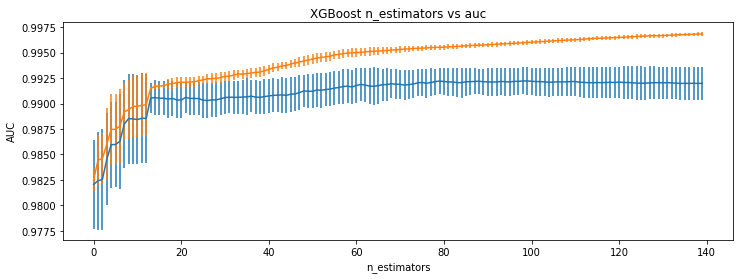

0.9907725398816142
{'min_child_weight': 10}


In [84]:
param_test2b = {
 'min_child_weight':[6,8,10,12]
}
gsearch2b = GridSearchCV(estimator = XGBClassifier( learning_rate=0.1, n_estimators=140, max_depth=4,
                         min_child_weight=2, gamma=0, subsample=0.8, colsample_bytree=0.8,
                         objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
                         param_grid = param_test2b, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch2b.fit(train[predictors],train[target])

modelfit(gsearch2b.best_estimator_, train, predictors)
print(gsearch2b.best_score_)
print(gsearch2b.best_params_)

Step 3: Tune gamma

Now lets tune gamma value using the parameters already tuned above. 
Gamma can take various values but I’ll check for 5 values here.
You can go into more precise values as.

In [85]:
param_test3 = {
 'gamma':[i/10.0 for i in range(0,5)]
}
gsearch3 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=140, max_depth=4,
 min_child_weight=6, gamma=0, subsample=0.8, colsample_bytree=0.8,
 objective= 'binary:logistic', nthread=4, scale_pos_weight=1,seed=27), 
 param_grid = param_test3, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch3.fit(train[predictors],train[target])

print(gsearch3.best_score_)
print(gsearch3.best_params_)

0.990476665148152
{'gamma': 0.2}


This shows that our original value of gamma, i.e. 0 is the optimum one. Before proceeding, 
a good idea would be to re-calibrate the number of boosting rounds for the updated parameters.


Model Report
Accuracy : 0.9911
AUC Score (Train): 0.995696
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8, 'verbosity': 0}


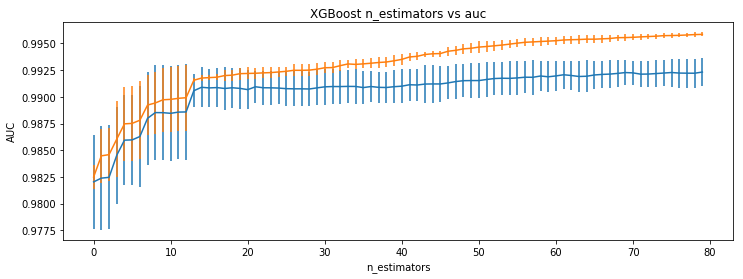

In [86]:
xgb2 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=4,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
modelfit(xgb2, train, predictors)

Step 4: Tune subsample and colsample_bytree

The next step would be try different subsample and colsample_bytree values. 
Lets do this in 2 stages as well and take values 0.6,0.7,0.8,0.9 for both to start with.

In [87]:
param_test4 = {
  'subsample':[i/10.0 for i in range(6,10)],
  'colsample_bytree':[i/10.0 for i in range(6,10)]
}

gsearch4 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                                   min_child_weight=6, gamma=0, subsample=0.8, 
                                                   colsample_bytree=0.8, objective= 'binary:logistic', 
                                                   nthread=4, scale_pos_weight=1,seed=27), 
                                                   param_grid = param_test4, scoring='roc_auc',
                                                   n_jobs=4,iid=False, cv=5)
gsearch4.fit(train[predictors],train[target])

print(gsearch4.best_score_)
print(gsearch4.best_params_)

0.9906989678069937
{'colsample_bytree': 0.6, 'subsample': 0.9}


Here, we found 0.8 as the optimum value for both subsample 
and colsample_bytree. Now we should try values in 0.05 interval around these.

In [88]:
param_test5 = {
 'subsample':[i/100.0 for i in range(75,90,5)],
 'colsample_bytree':[i/100.0 for i in range(75,90,5)]
}
gsearch5 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                                   min_child_weight=6, gamma=0, subsample=0.8, 
                                                   colsample_bytree=0.8, objective= 'binary:logistic', 
                                                nthread=4, scale_pos_weight=1,seed=27), 

param_grid = param_test5, scoring='roc_auc',n_jobs=4,iid=False, cv=5)

gsearch5.fit(train[predictors],train[target])

print(gsearch5.best_score_)
print(gsearch5.best_params_)

0.9909491869845629
{'colsample_bytree': 0.75, 'subsample': 0.85}


Step 5: Tuning Regularization Parameters

Next step is to apply regularization to reduce overfitting.
Though many people don’t use this parameters much as gamma provides a substantial way of controlling complexity. 
But we should always try it. I’ll tune ‘reg_alpha’ value here and leave it upto you to 
try different values of ‘reg_lambda’.

In [89]:
param_test6 = {
 'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}
gsearch6 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                                   min_child_weight=6, gamma=0.1, subsample=0.8, 
                                                   colsample_bytree=0.8, objective= 'binary:logistic', 
                                                   nthread=4, scale_pos_weight=1,seed=27), 
                                                   param_grid = param_test6, scoring='roc_auc',
                                                   n_jobs=4,iid=False, cv=5)
gsearch6.fit(train[predictors],train[target])

print(gsearch6.best_score_)
print(gsearch6.best_params_)

0.9903277565215054
{'reg_alpha': 1e-05}


We can see that the CV score is less than the previous case. But the values tried are very widespread, 
we should try values closer to the optimum here (0.01) to see if we get something better.

In [90]:
param_test7 = {
 'reg_alpha':[0, 0.001, 0.005, 0.01, 0.05]
}
gsearch7 = GridSearchCV(estimator = XGBClassifier( learning_rate =0.1, n_estimators=177, max_depth=4,
                                                   min_child_weight=6, gamma=0.1, subsample=0.8, 
                                                   colsample_bytree=0.8, objective= 'binary:logistic', 
                                                   nthread=4, scale_pos_weight=1,seed=27), 
                                                   param_grid = param_test7, scoring='roc_auc',
                                                   n_jobs=4,iid=False, cv=5)
gsearch7.fit(train[predictors],train[target])

print(gsearch7.best_score_)
print(gsearch7.best_params_)

0.9903277565215054
{'reg_alpha': 0}



Model Report
Accuracy : 0.9908
AUC Score (Train): 0.995415
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 1000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.005, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8, 'verbosity': 0}


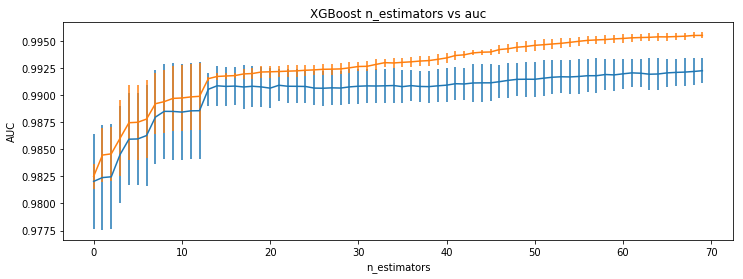

In [91]:
xgb3 = XGBClassifier(learning_rate =0.1,
                     n_estimators=1000,
                     max_depth=4,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     reg_alpha=0.005,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
modelfit(xgb3, train, predictors)                 

Step 6: Reducing Learning Rate

Lastly, we should lower the learning rate and add more trees.
Lets use the cv function of XGBoost to do the job again.


Model Report
Accuracy : 0.9877
AUC Score (Train): 0.990249
{'base_score': 0.5, 'booster': 'gbtree', 'colsample_bylevel': 1, 'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 4, 'min_child_weight': 6, 'missing': None, 'n_estimators': 5000, 'nthread': 4, 'objective': 'binary:logistic', 'reg_alpha': 0.005, 'reg_lambda': 1, 'scale_pos_weight': 1, 'seed': 27, 'silent': True, 'subsample': 0.8, 'verbosity': 0}


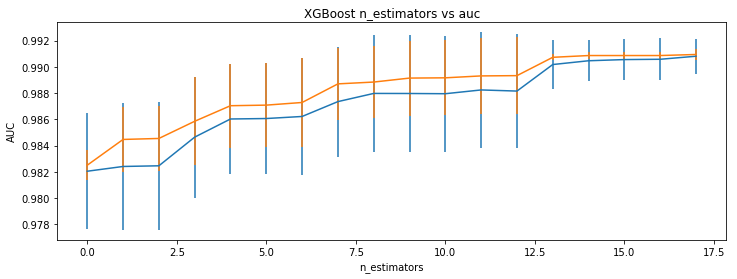

In [92]:
xgb4 = XGBClassifier(learning_rate =0.01,
                     n_estimators=5000,
                     max_depth=4,
                     min_child_weight=6,
                     gamma=0,
                     subsample=0.8,
                     colsample_bytree=0.8,
                     reg_alpha=0.005,
                     objective= 'binary:logistic',
                     nthread=4,
                     scale_pos_weight=1,
                     seed=27)
modelfit(xgb4, train, predictors)